# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

**Цель исследования** – ответить на следующие вопросы: 
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

Входные данные от банка — статистика о платёжеспособности клиентов из файла datasets/data.csv. 

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


## Шаг 1. Общая информация

Покдлючим необходимые для работы библиотеки и инструменты, начнем работу с базой:

In [67]:
# for pymystem proper work https://github.com/nlpub/pymystem3/issues/28
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-10-19 10:21:46--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.241, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-10-19 10:21:46--  http://cachev2-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm910.cdn.yandex.net (cachev2-mskm910.cdn.yandex.net)... 5.45.220.121, 2a02:6b8:0:2002::921
Connecting to cachev2-mskm910.cdn.yandex.net (cachev2-mskm910.cdn.yandex.net)|5.45.220.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.4’

mystem-3.0-linux

In [68]:
import pandas as pd
import seaborn as sns # импорт библиотеки для визуализации
from pymystem3 import Mystem # импорт библиотеки для лемматизации
m = Mystem()

In [69]:
# настройка параметров отображения
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [70]:
clients = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv') # чтение файла с данными и сохранение в таблицу clients

In [71]:
clients.info() # получение общей информации о данных в таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В исходной таблице 12 столбцов и 21525 записей с разными типами данных.



Видим, что количество записей в столбцах `days_employed` и `total_income` отличается от общего в меньшую сторону, значит там есть **пропуски значений**.

In [72]:
clients.head(15) # просмотр первых 15 строк таблицы

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,-4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,-5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,-4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу
5,0,-926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.57,покупка жилья
6,0,-2879.20,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.97,операции с жильем
7,0,-152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.93,образование
8,2,-6929.87,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.83,на проведение свадьбы
9,0,-2188.76,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.94,покупка жилья для семьи


Видим отрицательные значения в столбце `days_employed` и записи, которые выглядят аномально (340266 дней трудового стажа в строке с индексом 4) – вероятно, введены **ошибочные данные**. Также видим пример **пропущенных значений** в строке с индексом 12.

**Вывод**

Мы получили и изучили файл с данными в формате csv. В каждой строке таблицы — информация о клиентах банка. Колонки имеют разные типы данных. 

<br>Согласно документации к данным:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

Стилистических ошибок в названиях столбцов нет. 

**Обнаруженные проблемы:**
1. пропуски значений в столбце `days_employed`
2. отрицательные значения в столбце `days_employed`
3. ошибочные значения (выбросы) в столбце `days_employed`
4. пропуски значений в столбце `total_income`
5. некорректный тип данных в столбце `days_employed`
6. дубликаты из-за различия в регистре в столбце `education`
7. дубликаты из-за различных формулировок в столбце `purpose`

Предварительно можно утверждать, что данных в таблице достаточно для получения ответов на вопросы клиента. 
Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Шаг 2. Предобработка данных

### Обработка пропусков

Посчитаем количество пропущенных значений в таблице.

In [73]:
clients.isna().sum() # подсчет суммы пропущенных значений в столбцах

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Мы обнаружили пропущенные значения в столбцах `days_employed` и `total_income`.

Вероятно, отсутствие данных здесь **неслучайно** – некоторые клиенты могут не иметь официального трудового стажа и официального дохода или просто не желают заполнять эти поля, если они не обязательны.

<br>
Для начала оценим, насколько удаление пропусков может повредить расчётам и, если доля велика, будем заполнять пропуски явными обозначениями. 

In [74]:
nan_percentage = 2174 / 21525 * 100 # расчет процента пропусков от всей базы 
display(nan_percentage)

10.099883855981417

Доля пропущенных значений – 10%, это довольно большой сегмент, поэтому мы не будем его удалять, а заполним рассчитанными данными.

#### Обработка найденных проблем в столбце `days_employed`

Начнем со столбца `days_employed` и решим сразу 3 найденные в нем проблемы: отрицательные значения, пропущенные значения и выбросы.


1. Исправим проблему с отрицательными значениями, переведя их в абсолютные:

In [75]:
clients['days_employed'] = abs(clients['days_employed']) # перевод значений в абсолютные

In [76]:
clients.head() # проверка, значения в `days_employed` стали положительными

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу


<div class="alert alert-info">
<b>Комментарий:</b>
<br>Далее буду реже приводить промежуточные этапы-проверки успешности замены данных или этапы расчетов с выводом медианных значений, чтобы не захламлять проект. Для промежуточных проверок на разных этапах использовались .head, .loc и display().
</div>

2. Посчитаем количество артефактов (выбросов) в этом столбце. 

Преположим, что максимальное значение трудового стажа может быть 65 лет или около 24000 дней.

In [77]:
clients[clients['days_employed'] > 24000]['days_employed'].count() # подсчет количества выбросов

3445


Заполним выбросы приближенными к реальным значениями, предположив, что имел место быть **ошибочный ввод трудового стажа в часах вместо дней**. Разделим значения в часах на 24, чтобы получить значения в днях:

In [78]:
for row in clients['days_employed']:
        if row > 24000:
            clients['days_employed'] = clients['days_employed'].replace(row, row / 24)
        
# заполнение выбросов в столбце days_employed методом replace

3. Заполним пропущенные значения в столбце `days_employed` медианой по `dob_years`.

Предположим, что количество дней трудового стажа больше всего коррелирует с возрастом клиента, поэтому средний показатель будем высчитывать исходя из этой гипотезы.

In [79]:
for year in clients['dob_years'].unique():
    median = clients.loc[clients['dob_years']==year, 'days_employed'].median()
    clients.loc[(clients['days_employed'].isna()) & (clients['dob_years']==year), 'days_employed'] = median
    
# заполнение пропусков в столбце days_employed медианным значением dob_years с помощью loc

#### Обработка найденных проблем в столбце `total_income`

Заполним пропуски в столбце `total_income` медианными значениями по `income_type`.

Предположим, что месячный доход больше всего коррелирует с типом занятости, поэтому средний показатель будет высчитывать исходя из этой гипотезы.

In [80]:
for value in clients['income_type'].unique(): 
    median = clients.loc[clients['income_type']==value, 'total_income'].median()
    clients.loc[(clients['total_income'].isna()) & (clients['income_type']==value), 'total_income'] = median
    
# заполнение пропусков в столбце total_income медианным значением группы по income_type с помощью loc

<div class="alert alert-block alert-success">
<b>Комментарий:</b> В будущем такой препроцессинг можно свести к одной строчке кода:
<code>clients['total_income'].fillna(clients.groupby('income_type')['total_income'].transform('median'))</code>
</div>

In [81]:
clients.isna().sum() # проверка пропусков, должны быть нули

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [82]:
clients.loc[12] # проверка, что в строке с индексом 12 пропуски поменялись на медианы

children                           0
days_employed               14902.85
dob_years                         65
education                    среднее
education_id                       1
family_status       гражданский брак
family_status_id                   1
gender                             M
income_type                пенсионер
debt                               0
total_income               118514.49
purpose              сыграть свадьбу
Name: 12, dtype: object

**Вывод**

Мы проверили, повлияет ли удаление пропущенных данных на расчет и приняли решение, что удалять эти строки не стоит. 

Заменили пропущенные значения на медианные, исходя из предположений корреляции одних данных с другими. Поменяли неверный формат у выбросов и сохранили остальные данные. 

Теперь заполнены все ячейки, но столбец `days_employed` имеет вещественный формат (числа с запятой), хотя дни изменяются целыми числами. Вероятнее всего, это ошибка типа данных. Продолжим предобработку и исправим этот недостаток для улучшения внешнего вида таблицы.

### Замена типа данных

У столбца `days_employed` вещественный тип данных, хотя для записи общего трудового стажа в днях очевидно нужен целочисленный – дни не измеряются дробными числами. В столбце с доходами `total_income` тоже удобнее будет использовать целые числа, поэтому можно сменить тип, округлив до рубля.

Сменим тип данных в обоих столбцах простым встроенным методом `astype`:

In [83]:
try:
    clients['days_employed'] = clients['days_employed'].astype('int')
except:
    print('при смене типа данных в days_employed произошла ошибка')

try: 
    clients['total_income'] = clients['total_income'].astype('int')
except:
    print('при смене типа данных в total_income произошла ошибка')


# замена типа данных и приведение значений к абсолютным с проверкой try-except

In [84]:
clients.dtypes # проверка смены типа данных

children             int64
days_employed        int64
dob_years            int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int64
purpose             object
dtype: object

**Вывод**

Мы улучшили человекочитабельность и внешний вид таблицы, поменяв тип данных с вещественного на целочисленный методом astype. 

При этом мы использовали конструкцию try - except, чтобы предотвратить пропажу расчётов для правильных строк, если бы случилась ошибка во время исполнения кода.

### Обработка дубликатов

#### Сначала посчитаем и удалим **явные дубликаты** в таблице.

In [85]:
clients.duplicated().sum() # подсчет явных дубликатов

54

Явные дубликаты означают полное совпадение строк. Вероятно, это повторные заявки на кредит, которые попали в систему по ошибке. 

Их можно просто удалить:

In [86]:
clients = clients.drop_duplicates().reset_index(drop=True) 
# удаление явных дубликатов со сбросом старых индексов и формированием новых, перезапись таблицы

#### Теперь посчитаем и удалим **неявные дубликаты** в столбце `education`.

In [87]:
clients['education'].sort_values().unique() # просмотр уникальных значений в столбце education

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

Записи одинаковые по значению, но написаны в разном регистре – приведем их к одному регистру, перезапишем данные и сравним внешний вид:

In [88]:
clients['education'] = clients['education'].str.lower()  # приведение строк к нижнему регистру встроенным методом

In [89]:
clients['education'].sort_values().unique() # просмотр уникальных значений в столбце education после обработки

array(['высшее', 'начальное', 'неоконченное высшее', 'среднее',
       'ученая степень'], dtype=object)

После очистки значений от неявных дубликатов могли появится новые явные дубликаты. 

Еще раз запустим удаление явных дубликатов со сбросом индексов таблицы и выведем результат:

In [90]:
clients = clients.drop_duplicates().reset_index(drop=True) 
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21454 non-null  int64 
 1   days_employed     21454 non-null  int64 
 2   dob_years         21454 non-null  int64 
 3   education         21454 non-null  object
 4   education_id      21454 non-null  int64 
 5   family_status     21454 non-null  object
 6   family_status_id  21454 non-null  int64 
 7   gender            21454 non-null  object
 8   income_type       21454 non-null  object
 9   debt              21454 non-null  int64 
 10  total_income      21454 non-null  int64 
 11  purpose           21454 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Мы почистили таблицу от явных дубликатов. После удаления от 21525 записей осталось 21454. Исследование станет более точным.

Из-за разного написания одинаковых терминов в столбце с уровнем образования, количество значений в нем дублировалось неявно (компьютер не мог распознать их как однозначные, тогда как человек может). Мы избавились от неявных дублей в названиях и улучшили читаемость таблицы – как для компьютера, так и для человека.

### Лемматизация

Посмотрим на значения в столбце `purpose`. В нем текстовый тип данных, что значит большую вероятность наличия ошибок, опечаток или неявных дублей.

In [91]:
clients['purpose'].value_counts() # просмотр уникальных значений в столбце purpose с сортировкой по частоте

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Обнаружены одинаковые по смыслу значения в разном написании. Снова **неявные дубли**, но уже с более сложной проблемой – не просто разница в регистре, а различные формулировки с однокоренными словами.

<br>Чтобы опознать разные формы слов, воспользуемся библиотекой `pymystem3` для лемматизации – приведения слов к их словарной форме.

Создадим список для работы из всех значений столбца `purpose`.

In [92]:
purposes = [] # создание списка из всех уникальных значений в столбце purpose
for row in clients['purpose']:
    if row not in purposes:
        purposes.append(row)

print(purposes)

['покупка жилья', 'приобретение автомобиля', 'дополнительное образование', 'сыграть свадьбу', 'операции с жильем', 'образование', 'на проведение свадьбы', 'покупка жилья для семьи', 'покупка недвижимости', 'покупка коммерческой недвижимости', 'покупка жилой недвижимости', 'строительство собственной недвижимости', 'недвижимость', 'строительство недвижимости', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'операции с коммерческой недвижимостью', 'строительство жилой недвижимости', 'жилье', 'операции со своей недвижимостью', 'автомобили', 'заняться образованием', 'сделка с подержанным автомобилем', 'получение образования', 'автомобиль', 'свадьба', 'получение дополнительного образования', 'покупка своего жилья', 'операции с недвижимостью', 'получение высшего образования', 'свой автомобиль', 'сделка с автомобилем', 'профильное образование', 'высшее образование', 'покупка жилья для сдачи', 'на покупку автомобиля', 'ремонт жилью', 'заняться высшим образованием']


In [93]:
lemmas = m.lemmatize(' '.join(purposes)) # поиск лемм в списке, сконвертированном в строку
print(lemmas)

['покупка', ' ', 'жилье', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'дополнительный', ' ', 'образование', ' ', 'сыграть', ' ', 'свадьба', ' ', 'операция', ' ', 'с', ' ', 'жилье', ' ', 'образование', ' ', 'на', ' ', 'проведение', ' ', 'свадьба', ' ', 'покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', ' ', 'покупка', ' ', 'недвижимость', ' ', 'покупка', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'покупка', ' ', 'жилой', ' ', 'недвижимость', ' ', 'строительство', ' ', 'собственный', ' ', 'недвижимость', ' ', 'недвижимость', ' ', 'строительство', ' ', 'недвижимость', ' ', 'на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', ' ', 'на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', ' ', 'операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'строительство', ' ', 'жилой', ' ', 'недвижимость', ' ', 'жилье', ' ', 'операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', ' ', 'автомобиль', ' ', 'заниматься', ' ', 'образование', ' ', 'сделка', ' ', 'с', ' ', 'подержать

<br>Посчитаем количество упоминаний уникальных лемм в тексте.

In [94]:
from collections import Counter # подключение контейнера Counter из модуля collections
print(Counter(lemmas)) # подсчёт числа лемм в тексте

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Разделим полученные леммы на категории, обобщив схожие понятия целей кредитования.
Глаголы и прилагательные здесь не значимы, оставляем только конечные цели.

<br>Получилось **5 категорий**:

1. жилая недвижимость
2. коммерческая недвижимость
3. автомобиль
4. образование
5. свадьба


Теперь нужно присвоить эти категории записям с разными формулировками.

Создадим функцию для поиска частей слов:

In [95]:
def purpose_group(purpose):
    """
    Возвращает название категории по вхождению корня слова в значения purpose, используя правила:
    - 'жилая недвижимость' = 'недвиж', 'жил', 'строит'
    - 'коммерческая недвижимость' = 'коммерч'
    - 'автомобиль' =  'автомоб'
    - 'свадьба' = 'свад'
    - 'образование' = 'образов'
    """
    
    if ('недвиж' in purpose 
       or 'жил' in purpose 
       or 'строит' in purpose):
        if 'коммерч' in purpose:
            return 'коммерческая недвижимость'
        return 'жилая недвижимость'
    if 'автомоб' in purpose:
        return 'автомобиль'
    if 'образов' in purpose:
        return 'образование'
    if 'свад' in purpose:
        return 'свадьба'
    return 'другое' # подстраховочный вариант

 Создадим отдельный столбец с новыми категориями, а в его ячейках запишем значения, возвращаемые функцией:

In [96]:
clients['purpose_grouped'] = clients['purpose'].apply(purpose_group) # аргументом метода является сама функция

In [97]:
clients['purpose_grouped'].unique()

array(['жилая недвижимость', 'автомобиль', 'образование', 'свадьба',
       'коммерческая недвижимость'], dtype=object)

**Вывод**

Мы выделили неявные дубли с помощью лемматизации, категоризировали запросы на основе подобия формулировок и создали столбец с новыми категориями, которых получилось 5.

### Категоризация данных

Для ответа на вопросы клиента нам нужны столбцы с данными по наличию детей, семейному положению, уровню дохода, целью кредита и наличию задолженностей по кредитам. 

Для успешного анализа сгруппируем данные, присвоив им категории.

#### Категоризируем столбец `children` – количество детей в семье:

In [98]:
clients['children'].value_counts() 

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Мы обнаружили 2 артефакта: значения -1 и 20 детей. Вероятно, это **случайные ошибки**. Мы не знаем точную причину их появления и можем либо удалить эти строки, либо попробовать угадать, какие данные на самом деле имелись ввиду.

Я выбрала удаление, так как количество записей с артефактами незначительное, значит их удаление не повлияет на результат вычислений.

In [99]:
clients.drop(clients[clients.children == 20].index, inplace=True) # последовательно удалим ненужные строки методом drop inplace
clients.drop(clients[clients.children == -1].index, inplace=True)

**Классифицируем данные** на 3 группы по следующим правилам:
1. 0 = бездетные
2. 1-2 = с 1-2 детьми
3. 3 и более = многодетные

In [100]:
def children_group(children):
    """
    Возвращает группу по значению количества детей в семье, используя правила:
    1. 0 = 'бездетные'
    2. 1-2 = 'с 1-2 детьми'
    3. 3 и более = 'многодетные'
    """
    
    if children == 0:
        return 'бездетные'
    elif 1 <= children <= 2:
        return 'с 1-2 детьми'
    return 'многодетные' 


Добавим в таблицу новый столбец с полученными значениями методом apply.

In [101]:
clients['children_category'] = clients['children'].apply(children_group)
# добавление нового столбца с применением метода apply и расчетом функции

clients['children_category'].value_counts()

бездетные       14091
с 1-2 детьми     6860
многодетные       380
Name: children_category, dtype: int64

Создадим словарь соответствия значений новым категориям и посмотрим все возможные варианты соответствия категориям:

In [102]:
children_dict = clients[['children_category', 'children']] # создание словаря из 2 столбцов
children_dict = children_dict.drop_duplicates().reset_index(drop=True)
children_dict

,children_category,children
0,с 1-2 детьми,1
1,бездетные,0
2,многодетные,3
3,с 1-2 детьми,2
4,многодетные,4
5,многодетные,5


#### Категоризируем столбец `family_status` – семейное положение:

In [103]:
clients['family_status'].value_counts()

женат / замужем          12261
гражданский брак          4134
Не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
Name: family_status, dtype: int64

Здесь у нас тоже готовые 5 категорий, а также в файле уже присутствует группировка по  `family_status_id`. 

Улучшим внешний вид записей, приведя их в нижний регистр:

In [104]:
clients['family_status'] = clients['family_status'].str.lower()  # приведение строк к нижнему регистру
clients['family_status'].value_counts()

женат / замужем          12261
гражданский брак          4134
не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
Name: family_status, dtype: int64

In [105]:
family_dict = clients[['family_status_id', 'family_status']] # создание словаря из 2 столбцов
family_dict = family_dict.drop_duplicates().reset_index(drop=True)
family_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


#### Категоризируем столбец `purpose_grouped` – цель кредита:

In [106]:
clients['purpose_grouped'].value_counts()

жилая недвижимость           9448
автомобиль                   4279
образование                  3988
свадьба                      2313
коммерческая недвижимость    1303
Name: purpose_grouped, dtype: int64

In [107]:
purpose_dict = clients[['purpose_grouped', 'purpose']] # создание словаря из 2 столбцов
purpose_dict = purpose_dict.drop_duplicates().reset_index(drop=True)
purpose_dict.head(10)

,purpose_grouped,purpose
0,жилая недвижимость,покупка жилья
1,автомобиль,приобретение автомобиля
2,образование,дополнительное образование
3,свадьба,сыграть свадьбу
4,жилая недвижимость,операции с жильем
5,образование,образование
6,свадьба,на проведение свадьбы
7,жилая недвижимость,покупка жилья для семьи
8,жилая недвижимость,покупка недвижимости
9,коммерческая недвижимость,покупка коммерческой недвижимости


#### Категоризируем столбец дохода `total_income` –  ежемесячный доход:

In [108]:
clients['total_income'].value_counts()

142594    1066
172357     498
118514     384
150447     144
150684       3
          ... 
127332       1
213236       1
67366        1
300306       1
82047        1
Name: total_income, Length: 18504, dtype: int64

Столбец содержит количественные данные – приведем их в категориальный вид, разделив доходы на следующие группы:

1. до 50 тысяч
2. от 50 до 100
3. от 100 до 150
4. от 150 до 200
5. от 200 и выше

In [109]:
def total_income_group(income):
    """
    Возвращает группу по значению дохода, используя правила:
    - Доход до 50
    - от 50 до 100
    - От 100 до 150
    - От 150 до 200
    - От 200 и выше
    """
    
    if income < 50000:
        return 'до 50 тысяч'
    elif 50000 <= income < 100000:
        return 'от 50 до 100'
    elif 100000 <= income < 150000:
        return 'от 100 до 150'
    elif 150000 <= income < 200000:
        return 'от 150 до 200'
    return 'от 200 и выше'

In [110]:
clients['total_income_grouped'] = clients['total_income'].apply(total_income_group) 
# добавление нового столбца с применением метода apply и расчетом функции

In [111]:
income_dict = clients[['total_income_grouped', 'total_income']] # создание словаря из 2 столбцов
income_dict = income_dict.drop_duplicates().reset_index(drop=True)
income_dict.head(10)

,total_income_grouped,total_income
0,от 200 и выше,253875
1,от 100 до 150,112080
2,от 100 до 150,145885
3,от 200 и выше,267628
4,от 150 до 200,158616
5,от 200 и выше,255763
6,от 200 и выше,240525
7,от 100 до 150,135823
8,от 50 до 100,95856
9,от 100 до 150,144425


#### Категоризируем столбец `debt` – имелась ли задолженность по возврату кредитов:

In [112]:
clients['debt'].value_counts()

0    19599
1     1732
Name: debt, dtype: int64

In [113]:
def debt_groupping(debt):
    if debt == 1:
        return 'есть задолженность'
    return 'нет задолженности'

In [114]:
clients['debt_grouped'] = clients['debt'].apply(debt_groupping) 
# добавление нового столбца с применением метода apply и расчетом функции

In [115]:
debt_dict = clients[['debt_grouped', 'debt']] # создание словаря из 2 столбцов
debt_dict = debt_dict.drop_duplicates().reset_index(drop=True)
debt_dict

,debt_grouped,debt
0,нет задолженности,0
1,есть задолженность,1


In [116]:
clients.reset_index(drop=True).info() # сброс индексов таблицы после удаления строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21331 entries, 0 to 21330
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   children              21331 non-null  int64 
 1   days_employed         21331 non-null  int64 
 2   dob_years             21331 non-null  int64 
 3   education             21331 non-null  object
 4   education_id          21331 non-null  int64 
 5   family_status         21331 non-null  object
 6   family_status_id      21331 non-null  int64 
 7   gender                21331 non-null  object
 8   income_type           21331 non-null  object
 9   debt                  21331 non-null  int64 
 10  total_income          21331 non-null  int64 
 11  purpose               21331 non-null  object
 12  purpose_grouped       21331 non-null  object
 13  children_category     21331 non-null  object
 14  total_income_grouped  21331 non-null  object
 15  debt_grouped          21331 non-null

**Вывод**

Мы рассмотрели столбцы, необходимые для расчетов, категоризировали данные в них и сгруппировали данные по словарям. 

Из-за артефактов в столбце с количеством детей пришлось удалить некоторые строки и сбросить индекс таблицы. Осталась 21331 строка.

В таком виде данные годятся для анализа.

## Шаг 3. Ответы на вопросы проекта

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

<div class="alert alert-info">
<b>Комментарий:</b>
<br>В первом вопросе я опишу подробно по шагам свои действия для формирования вывода, а в следующих вопросах буду сразу показывать результаты с выводами, без объяснений по шагам, так как действия повторяются.
</div>

1. Построим сводную таблицу с параметрами, необходимыми для расчета ответа на вопрос – категория с наличием детей и фактор задолженности:

In [117]:
children_pivot = clients.pivot_table(index=['children_category'], columns='debt', values='children', aggfunc='count')
children_pivot

debt,0,1
children_category,,
бездетные,13028,1063
многодетные,349,31
с 1-2 детьми,6222,638


2. Создадим функцию, которая будет считать процент задолженностей для каждой исследуемой категории. Ее мы будем вызывать и в последующих шагах:

In [118]:
def research_result(pivot):
    pivot['debt_ratio'] = (pivot[1] / (pivot[0] + pivot[1])) * 100
    return pivot.sort_values('debt_ratio', ascending=True)

# считаем долю клиентов с задолженностью для каждой исследуемой категории и выводим отсортированную по возрастанию доли таблицу

3. Создадим новую таблицу, вызвав функцию и передав аргументом сводную таблицу из 1 шага:

In [119]:
research_children = research_result(children_pivot)

4. Построим столбчатую диаграмму, передавая в ось x значения с процентом задолженностей, а в ось y - значения исследуемой категории:

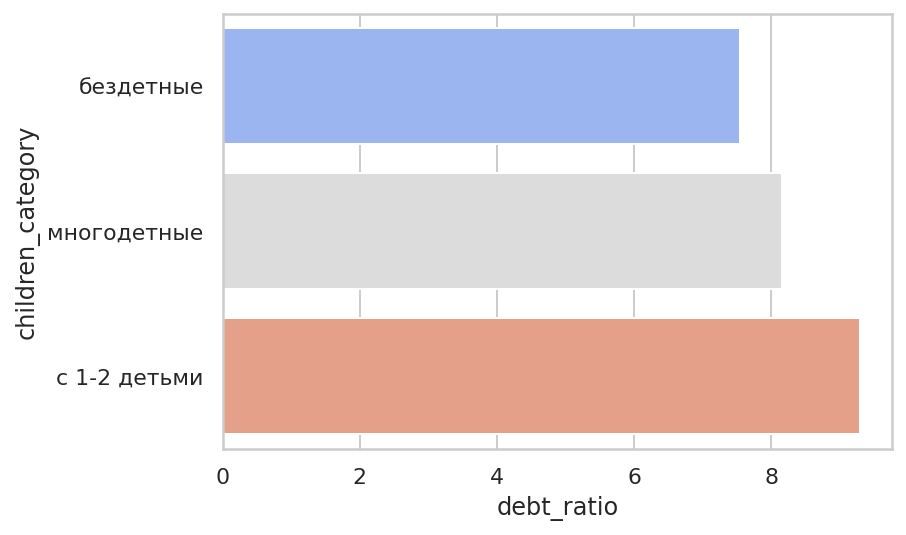

In [120]:
sns.barplot(x="debt_ratio", y=research_result(children_pivot).index, data=research_result(children_pivot), palette="coolwarm");

# строим график зависимости процента задолженности от наличия детей

На самом верху диаграммы находится самая ответственная группа заемщиков – отмечена холодным синим цветом. У нее самая низкая доля задолженностей среди всех займов по группе.

В самом низу диаграммы находятся заемщики с самым высоким процентом задолженностей – отмечены красным цветом. У нее самая большая доля задолженностей среди всех займов по группе.

5. Выведем средний коэфициент задолженности по всей выборке, чтобы сравнивать полученные значения с ним:

In [121]:
debt_mean = (clients['debt'].mean()) * 100
print('Средний процент задолженности по кредитам для всей выборки: {:.2f}%'.format(debt_mean))

Средний процент задолженности по кредитам для всей выборки: 8.12%


6. Напишем функцию, которая сравнит процент задолженности в категории со средним:

In [122]:
def debt_research(table):
    for idx, row in table.iterrows():
        row['children_category'] = idx
        debt_ratio = format(row['debt_ratio'], '.2f')
        if row['debt_ratio'] <= debt_mean:
            print('В категории "{idx}" задолженность составляет {debt_ratio}%. Это меньше среднего значения по выборке.'.format(idx=idx, debt_ratio=debt_ratio))  
        else:
            print('В категории "{idx}" задолженность составляет {debt_ratio}%. Это БОЛЬШЕ среднего значения по выборке.'.format(idx=idx, debt_ratio=debt_ratio))


In [123]:
debt_research(research_children) # применение функции к таблице research_children

В категории "бездетные" задолженность составляет 7.54%. Это меньше среднего значения по выборке.
В категории "многодетные" задолженность составляет 8.16%. Это БОЛЬШЕ среднего значения по выборке.
В категории "с 1-2 детьми" задолженность составляет 9.30%. Это БОЛЬШЕ среднего значения по выборке.


**Вывод**

На диаграмме видно, что значения задолженности в категориях значительно отличаются. <br><br>
Также мы определили, что в некоторых категориях присутствуют отклонения в большую сторону от среднего значения по выборке.<br>
Это категории семей с детьми.<br>
Самый благоприятный (низкий) процент задолженности у клиентов категории "бездетные".


Таким образом, можно утверждать, что зависимость между количеством детей в семье и возвратом кредита в срок **есть**.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Здесь я даже боюсь строить гипотезы. Казалось, что наоборот – люди без детей имеют более высокий процент рисков. Оказывается, наоборот.<br>
    Может быть это связано с наличием свободного времени у бездетных на расчет бюджетов? Или с большей вероятностью непредвиденных расходов у семей с детьми (болезнь, покупка одежды, ремонт), которые могут помешать оплате кредита в срок.<br><br> Если данные предоставлены реальные, то очень интересно узнать мнение настоящих аналитиков, почему получились такие цифры.
</div>

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [124]:
family_pivot = clients.pivot_table(index=['family_status'], columns='debt', values = 'children', aggfunc='count')
research_family = research_result(family_pivot)
research_family

debt,0,1,debt_ratio
family_status,,,
вдовец / вдова,888,63,6.62
в разводе,1105,84,7.06
женат / замужем,11334,927,7.56
гражданский брак,3749,385,9.31
не женат / не замужем,2523,273,9.76


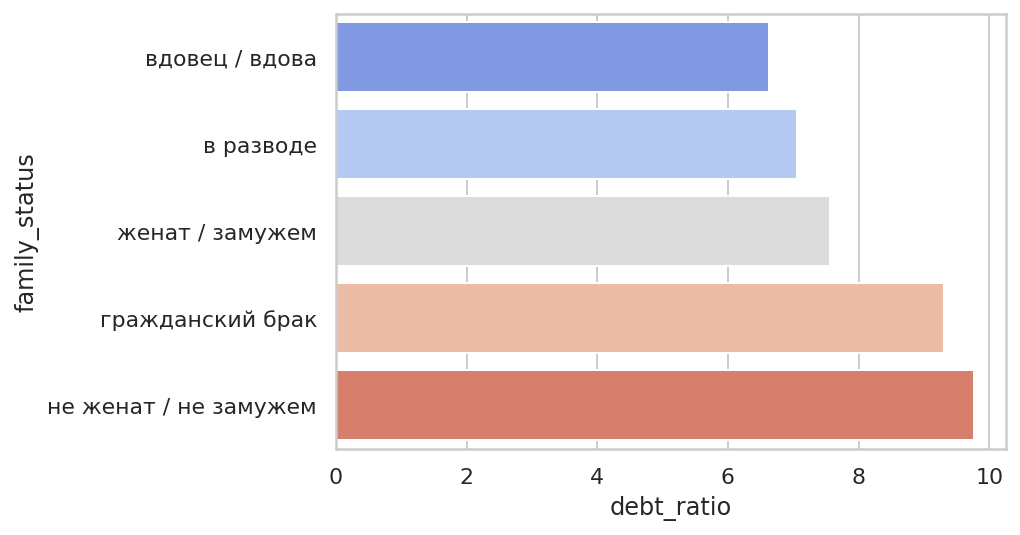

In [125]:
sns.barplot(x="debt_ratio", y=research_result(research_family).index, data=research_result(research_family), palette="coolwarm");

In [126]:
debt_research(research_family)

В категории "вдовец / вдова" задолженность составляет 6.62%. Это меньше среднего значения по выборке.
В категории "в разводе" задолженность составляет 7.06%. Это меньше среднего значения по выборке.
В категории "женат / замужем" задолженность составляет 7.56%. Это меньше среднего значения по выборке.
В категории "гражданский брак" задолженность составляет 9.31%. Это БОЛЬШЕ среднего значения по выборке.
В категории "не женат / не замужем" задолженность составляет 9.76%. Это БОЛЬШЕ среднего значения по выборке.


**Вывод**

На диаграмме видно, что значения задолженности в категориях значительно отличаются. <br><br>
Также мы определили, что в некоторых категориях присутствуют отклонения в большую сторону от среднего значения по выборке.<br>
Это категории с семейным положением "гражданский брак" и "не женат / не замужем".<br>
Самый благоприятный (низкий) процент задолженности у клиентов категории "вдовец / вдова".


Таким образом, можно утверждать, что зависимость между семейным положением и возвратом кредита в срок **есть**.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Есть гипотеза, что высокий процент долгов у неженатых может быть связан с пониженным уровнем социальной ответственности – они отвечают персонально за себя, но не за семью, поэтому могут себе позволить погрешности.<br>
У женатых людей есть поддержка от супруга – многие семьи кредиты выплачивают вместе.<br><br>
Насчет овдовевших и разведенных гипотез нет – разве что это в целом более зрелые люди, как по уровню ответственности, так и по возрасту. Тут уже нужно глубже смотреть корреляции с другими метриками – возрастом, целью кредита, наличием детей, уровнем зп и т.д.<br><br>
Вообще, это интересная тема для социологического исследования :)
</div>

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [127]:
income_pivot = clients.pivot_table(index=['total_income_grouped'], columns='debt', values = 'children', aggfunc='count')
research_income = research_result(income_pivot)
research_income

debt,0,1,debt_ratio
total_income_grouped,,,
до 50 тысяч,348,23,6.20
от 200 и выше,4683,356,7.06
от 50 до 100,3742,331,8.13
от 150 до 200,4335,403,8.51
от 100 до 150,6491,619,8.71


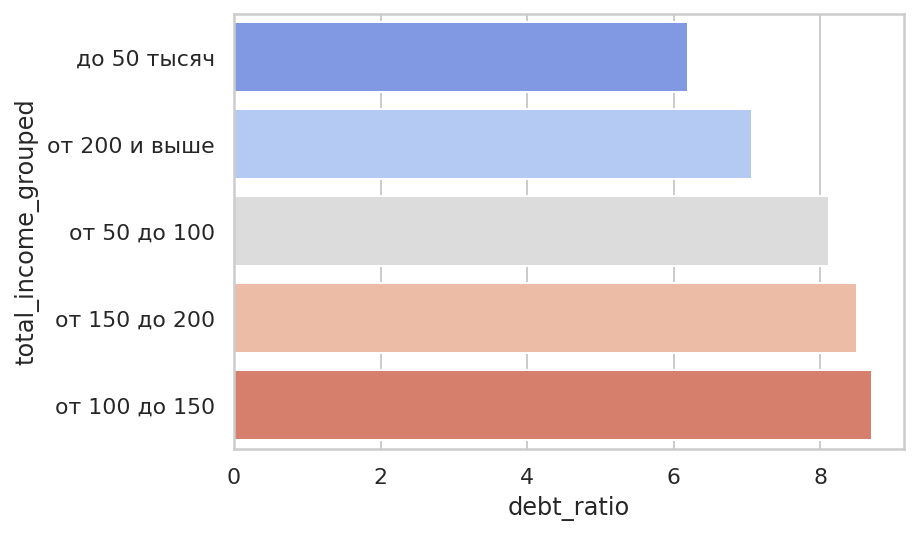

In [128]:
sns.barplot(x="debt_ratio", y=research_income.index, data=research_income, palette="coolwarm");

In [129]:
debt_research(research_income)

В категории "до 50 тысяч" задолженность составляет 6.20%. Это меньше среднего значения по выборке.
В категории "от 200 и выше" задолженность составляет 7.06%. Это меньше среднего значения по выборке.
В категории "от 50 до 100" задолженность составляет 8.13%. Это БОЛЬШЕ среднего значения по выборке.
В категории "от 150 до 200" задолженность составляет 8.51%. Это БОЛЬШЕ среднего значения по выборке.
В категории "от 100 до 150" задолженность составляет 8.71%. Это БОЛЬШЕ среднего значения по выборке.


**Вывод**

На диаграмме видно, что значения задолженности в категориях значительно отличаются. <br><br>
Также мы определили, что в некоторых категориях присутствуют отклонения в большую сторону от среднего значения по выборке.<br>
Это категории с уровнем дохода "от 50 до 100", "от 100 до 150" и "от 150 до 200".<br>
Самый благоприятный (низкий) процент задолженности у клиентов с доходом "до 50 тысяч".


Таким образом, можно утверждать, что зависимость между уровнем дохода и возвратом кредита в срок **есть**.

<div class="alert alert-info">
<b>Комментарий:</b>
Предположу, что люди с низким доходом более педантичны в расчетах бюджетов, стараются не допустить лишних расходов – пени и штрафов. <br><br>
Категория со средним доходом получилась довольно объемная, туда входят очень разные типажи личностей и демографические портреты. В целом в этом сегменте наверняка кредиты распространены и часты. Возможно даже берут сразу несколько кредитов, за которыми сложно следить. Но и штрафы/пени не так критичны, если доход позволяет. Поэтому относятся к этому более беспечно.<br><br>
Тут тоже интересно бы посмотреть корреляцию с другими метриками, в том числе которых в файле нет (например, интерсно количество открытых кредитов на 1 клиента).
</div>

### Как разные цели кредита влияют на его возврат в срок?

In [130]:
purpose_pivot = clients.pivot_table(index=['purpose_grouped'], columns='debt', values = 'children', aggfunc='count')
research_purpose = research_result(purpose_pivot)
research_purpose

debt,0,1,debt_ratio
purpose_grouped,,,
жилая недвижимость,8766,682,7.22
коммерческая недвижимость,1205,98,7.52
свадьба,2130,183,7.91
образование,3619,369,9.25
автомобиль,3879,400,9.35


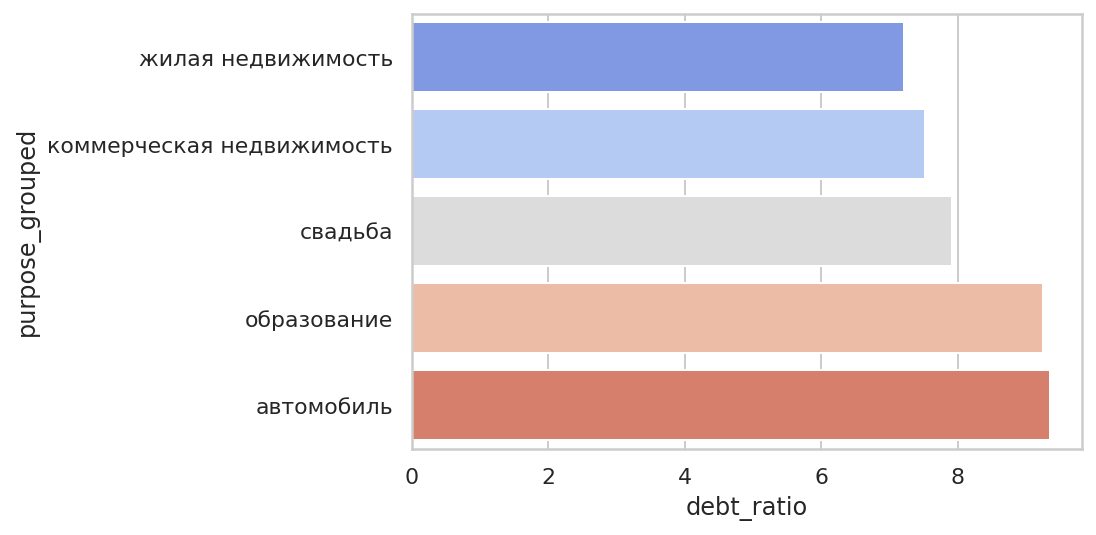

In [131]:
sns.barplot(x="debt_ratio", y=research_purpose.index, data=research_purpose, palette="coolwarm");

In [132]:
debt_research(research_purpose)

В категории "жилая недвижимость" задолженность составляет 7.22%. Это меньше среднего значения по выборке.
В категории "коммерческая недвижимость" задолженность составляет 7.52%. Это меньше среднего значения по выборке.
В категории "свадьба" задолженность составляет 7.91%. Это меньше среднего значения по выборке.
В категории "образование" задолженность составляет 9.25%. Это БОЛЬШЕ среднего значения по выборке.
В категории "автомобиль" задолженность составляет 9.35%. Это БОЛЬШЕ среднего значения по выборке.


**Вывод**

На диаграмме видно, что значения задолженности в категориях значительно отличаются. <br><br>
Также мы определили, что в некоторых категориях присутствуют отклонения в большую сторону от среднего значения по выборке.<br>
Это категории с целью кредита "образование" и "автомобиль".<br>
Самый благоприятный (низкий) процент задолженности у клиентов с целью "жилая недвижимость".


Таким образом, можно утверждать, что зависимость между целью кредита и возвратом кредита в срок **есть**.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Предположу, что кредиты на автомобиль и образование склонны брать более молодые и рисковые клиенты. Кроме того, кредит на образование сейчас зачастую подразумевает смену профессиональной деятельности ради более высоких доходов (например, свитчеры в IT). Это тоже оставляет свой след – одновременно работать и учиться, при этом отдавая часть дохода на образование, довольно сложно. Особенно в молодом возрасте, когда есть много расходов на личную жизнь, аренду квартиры и т.д.<br><br>
Займы на жилую недвижимость скорее всего берут люди семейные, которые выплачивают кредит вместе, иногда и с помощью родственников. Это ответственный жизненный этап, а платежи по ипотеке довольно крупные – пени могут быть болезненными. И отказаться от ипотеки довольно сложно – это жилье, основа существования. Так что приходится следить за бюджетом и отдавать в срок.
</div>

## Шаг 4. Общий вывод

В проекте для расчета способностей потенциального заёмщика вернуть кредит банку мы использовали инструментарий Python, pandas и seaborn.

Были расчитаны средние значения по выборкам и даны аргументированные ответы на вопросы:
- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

По всем вопросам дан положительный ответ – **найдена корреляция между рассмотренными категориями заемщиков и возвратом кредита в срок**.